In [1]:
pip install fredapi


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: C:\Users\jean-\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import os
import re
from fredapi import Fred
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
pd.reset_option("all")

C:\Users\jean-\AppData\Local\Temp\ipykernel_18528\3365680546.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option("all")
C:\Users\jean-\AppData\Local\Temp\ipykernel_18528\3365680546.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


# I - Getting the data 

For the US, we use the FRED database, available on the St Louis website, which contains a wide range of macroeconomic variables with monthly frequency. We will extract data using the FRED API and then store everything in a dataframe.

### 1) Extracting data with the API

In [4]:
api_key = '615add3bd441c0ed42dec47e952d69e2'
fred = Fred(api_key=api_key)

After many iterations, we get the following variables, which take some values between 2003-01-02 and 2025-08-01. For each of these variables, we tried to get the highest frequency of observations proposed by FRED database:
- for most financial markets data, we have daily observations
- for most macroeconomic variables, we have monthly observations
- for most fiscal variables, we have quarterly observations

Here is a list of the variables we extracted. Unfortunately, some important variables such as gold or SP500 were missing, so we will have to get these datas somewhere else.

In [5]:


variables_to_keep = [#production and revenue variables
                    'RPI',  #Real personal income; monitored by FED for interest rates decisions
                   'INDPRO', #Industrial production index; leading indicator of economic health, monitored by FED 
                   #job market variables
                   'UNRATE', #unemployment rate
                   'UEMP5TO14', #unemployment for people unemployed between 5 and 14 weeks = short term unemployment
                   'UEMP27OV', #unemployment for people unemployed for 27 weeks and over = long term unemployment
                    'PAYEMS', #total non farm payroll, leading indicator of employment
                    'USGOOD',   #below is the breakdown of employment figures for various economic sectors
                    'CES1021000001',
                    'USCONS',
                    'MANEMP',
                    'DMANEMP',
                    'NDMANEMP',
                    'SRVPRD',
                    'USTPU',
                    'USWTRADE',
                    'USTRADE',
                    'USFIRE',
                    'USGOVT',
                    #consumption and housing
                    'HOUST', #housing variable, sensitive to interest rates and economic anticipations
                    'PERMIT', #same but for building permits
                    'UMCSENT', #university of michigan consumer sentiment index, important for consumption anticipations
                    #money and credit variables
                    'M1SL', #monetary base, important for interest rates and inflation anticipations
                    'M2SL', 
                    'M2REAL', #real monetary base
                    'TOTRESNS', #total reserves of banks
                    'NONBORRES', #non borrowable reserves of banks
                    'BUSLOANS', #business loans, important for growth anticipations
                    'REALLN', #real loans, related to economic activity
                    'NONREVSL', #non-revolving consumer credit, related to consumption
                    'DTCOLNVHFNM', #total nonfinancial corporate business liabilities, related to economic activity
                    'DTCTHFNM', #total household liabilities, related to consumption
                    'INVEST', #gross private domestic investment, related to economic activity
                    #price indexes
                    'CPIAUCSL', #principal measure for inflation monitored by FED
                    'CPIAUCSL', 'CPIAPPSL', 'CPITRNSL','CPIMEDSL', 'CUSR0000SAC', 'CUUR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUUR0000SA0L2', 'CUSR0000SA0L5', #breakdown of the index for various sectors
                    'PCEPI', #inflation target for FED
                    'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA', #spendings for services, durable and nondurable goods
                    #fiscal variables
                    'FGEXPND', #quarterly federal government expenditures
                    'FGRECPT', #quarterly federal government receipts
                    'FGDEF',   #quarterly federal government budget deficit
                    'FGCE', # quarterly federal government spending
                    'MTSDS133FMS', # monthly federal surplus or deficit
                    'FYGFDPUN', #federal debt held by the public, quarterly 
                     'GFDEGDQ188S', #debt to gdp ratio, quarterly 
                     'A091RC1Q027SBEA', #net interest payment, quarterly 
                     'GFDEBTN', #total debt outstanding, monthly 
                     #yield variables
                     'DGS1MO', 'DGS3MO', 'DGS6MO', #yields on treasury bills with maturities < 1y
                    'DGS1', 'DGS2', 'DGS3','DGS5','DGS7', 'DGS10', 'DGS20', 'DGS30', #yields of government treasuries for maturies >=1y
                    #'GS1M','TB3MS','TB6MS', #yield on commercial paper
                    #'GS1', 'GS2', 'GS3','GS5','GS7', 'GS10', 'GS20', 'GS30', #yields of government treasuries for maturies >=1y  
                    #yields of other "safe haven"
                    'IRLTLT01DEM156N', #10y german bund yield
                    'IRLTLT01JPM156N', #10y japanese gov yield
                    'IRLTLT01GBM156N', #10y uk gilt yield
                    'IRLTLT01CAM156N', #10y canadian gov yield
                    'IRLTLT01AUM156N', #10y australian gov yield
                    'IRLTLT01FRM156N', #10y french gov yield
                    #stock markets
                    'NASDAQCOM', #nasdaq
                    #USD FX rates and US corporate bonds variables
                    'AAA', 'BAA', #yields of corporate bonds with notations AAA and BAA
                    'DEXUSEU', #usd to euro exchange rate
                    'DEXJPUS', #usd to yen exchange rate
                    'DEXUSUK', #usd to gbp exchange rate
                    'DEXCAUS', #usd to cad exchange rate
                    'DEXUSAL', #usd to aud exchange rate
                    'DEXCHUS', #usd to yuan exchange rate
                    #other financial variables measuring risk on / risk off 
                    'VIXCLS', #vix index, measure of market volatility
                    'NFCI', #national financial conditions index
                    'DCOILWTICO', #crude oil price, important for inflation anticipation
                     #interest rates variables (traditional monetary policy)
                    'FEDFUNDS', #federal funds rate, short term interest rates
                    'WRESBAL', #measure of liquidity in the banking system
                    'CURRCIR', #currency in circulation
                    'WTREGEN', #government deposits 
                    #QE and QT variables 
                    'BOGMBASE', #monetary base
                    'WSHOSHO', #total assets of FED = size of balance sheet
                    'WSHOTSL', #total treasuries held by FED
                    'WSHOBL', #total longer duration trasuries held by FED (for long end of yield curve)
                    #anticipations of inflation by markets
                    'T5YIE', #5y forward inflation expectation
                    'T10YIE', #10y forward inflation expectation

                    ]




start_date = '2002-09-01' #we don't do a start date before, because lots of data are missing before that date 
end_date   = '2025-08-01'


In [6]:
data = {}
for code_variable in variables_to_keep:
    print(code_variable)
    try:
        series = fred.get_series(code_variable, observation_start=start_date, observation_end=end_date)
        data[code_variable] = series
    except ValueError:
        print(f"Could not retrieve data for {code_variable}")
        continue

RPI
INDPRO
UNRATE
UEMP5TO14
UEMP27OV
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
HOUST
PERMIT
UMCSENT
M1SL
M2SL
M2REAL
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
DTCOLNVHFNM
DTCTHFNM
INVEST
CPIAUCSL
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUUR0000SAD
CUSR0000SAS
CPIULFSL
CUUR0000SA0L2
CUSR0000SA0L5
PCEPI
DDURRG3M086SBEA
DNDGRG3M086SBEA
DSERRG3M086SBEA
FGEXPND
FGRECPT
FGDEF
FGCE
MTSDS133FMS
FYGFDPUN
GFDEGDQ188S
A091RC1Q027SBEA
GFDEBTN
DGS1MO
DGS3MO
DGS6MO
DGS1
DGS2
DGS3
DGS5
DGS7
DGS10
DGS20
DGS30
IRLTLT01DEM156N
IRLTLT01JPM156N
IRLTLT01GBM156N
IRLTLT01CAM156N
IRLTLT01AUM156N
IRLTLT01FRM156N
NASDAQCOM
AAA
BAA
DEXUSEU
DEXJPUS
DEXUSUK
DEXCAUS
DEXUSAL
DEXCHUS
VIXCLS
NFCI
DCOILWTICO
FEDFUNDS
WRESBAL
CURRCIR
WTREGEN
BOGMBASE
WSHOSHO
WSHOTSL
WSHOBL
T5YIE
T10YIE


In [34]:
df = pd.concat(data, axis=1)
df.columns = data.keys()

In [35]:
df = df[df.index>='2002-09-01']
df = df.ffill()
df= df.bfill()

In [26]:
pd.reset_option('all')

C:\Users\jean-\AppData\Local\Temp\ipykernel_18528\2786130087.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\jean-\AppData\Local\Temp\ipykernel_18528\2786130087.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


In [ ]:
df = df[df.index>='2002-09-02']
df.index = pd.to_datetime(df.index)

df = df.resample('W-FRI').last()
df

,RPI,INDPRO,UNRATE,UEMP5TO14,UEMP27OV,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,...,FEDFUNDS,WRESBAL,CURRCIR,WTREGEN,BOGMBASE,WSHOSHO,WSHOTSL,WSHOBL,T5YIE,T10YIE
2002-09-06,11994.021,90.6373,5.7,2526.0,1580.0,130503.0,22396.0,505.5,6702.0,15119.0,...,1.75,13.059,662.189,4.795,680.4,629407.0,629397.0,226682.0,1.30,1.64
2002-09-13,11994.021,90.6373,5.7,2526.0,1580.0,130503.0,22396.0,505.5,6702.0,15119.0,...,1.75,6.731,662.189,5.009,680.4,629407.0,629397.0,226682.0,1.30,1.64
2002-09-20,11994.021,90.6373,5.7,2526.0,1580.0,130503.0,22396.0,505.5,6702.0,15119.0,...,1.75,8.454,662.189,5.773,680.4,629407.0,629397.0,226682.0,1.30,1.64
2002-09-27,11994.021,90.6373,5.7,2526.0,1580.0,130503.0,22396.0,505.5,6702.0,15119.0,...,1.75,6.464,662.189,6.832,680.4,629407.0,629397.0,226682.0,1.30,1.64
2002-10-04,12014.380,90.3988,5.7,2512.0,1653.0,130617.0,22323.0,506.4,6689.0,15059.0,...,1.75,12.465,662.238,6.182,681.9,629407.0,629397.0,226682.0,1.30,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-04,20625.729,103.8194,4.2,2034.0,1826.0,159518.0,21651.0,577.4,8302.0,12734.0,...,4.33,3225.980,2399.266,359.516,5740.0,6349167.0,4208325.0,195418.0,2.37,2.33
2025-07-11,20625.729,103.8194,4.2,2034.0,1826.0,159518.0,21651.0,577.4,8302.0,12734.0,...,4.33,3330.249,2399.266,319.889,5740.0,6349369.0,4208526.0,195418.0,2.44,2.37
2025-07-18,20625.729,103.8194,4.2,2034.0,1826.0,159518.0,21651.0,577.4,8302.0,12734.0,...,4.33,3398.822,2399.266,296.247,5740.0,6347296.0,4206523.0,195493.0,2.50,2.41
2025-07-25,20625.729,103.8194,4.2,2034.0,1826.0,159518.0,21651.0,577.4,8302.0,12734.0,...,4.33,3362.277,2399.266,323.176,5740.0,6343851.0,4206720.0,195493.0,2.47,2.44


In [38]:
df = df[df.index>='2003-01-02']

In [39]:
data_fred_path = os.path.join('data', 'US', 'data_fred_weekly.csv')
df.to_csv(data_fred_path,index = True)

after inspecting the data, we will proceed to the following transformations on each time series: 
- logdiff means taking log return
- diff means taking difference 
- remove means deleting the time series

In [43]:
dic_modif = {'RPI': ['logdiff'],
 'INDPRO': ['logdiff'],
 'UNRATE': ['logdiff'],
 'UEMP5TO14': ['logdiff'],
 'UEMP27OV': ['remove'],
 'PAYEMS': ['logdiff'],
 'USGOOD': ['logdiff'],
 'CES1021000001': ['remove'],
 'USCONS': ['logdiff'],
 'MANEMP': ['logdiff'],
 'DMANEMP': ['logdiff'],
 'NDMANEMP': ['logdiff'],
 'SRVPRD': ['logdiff'],
 'USTPU': ['logdiff'],
 'USWTRADE': ['logdiff'],
 'USTRADE': ['logdiff'],
 'USFIRE': ['logdiff'],
 'USGOVT': ['logdiff'],
 'HOUST': ['logdiff'],
 'PERMIT': ['logdiff'],
 'UMCSENT': ['logdiff'],
 'M1SL': ['logdiff'],
 'M2SL': ['logdiff'],
 'M2REAL': ['logdiff'],
 'TOTRESNS': ['logdiff'],
 'NONBORRES': ['remove'],
 'BUSLOANS': ['remove'],
 'REALLN': ['remove'],
 'NONREVSL': ['logdiff'],
 'DTCOLNVHFNM': ['logdiff'],
 'DTCTHFNM': ['logdiff'],
 'INVEST': ['remove'],
 'CPIAUCSL': ['logdiff'],
 'CPIAPPSL': ['logdiff'],
 'CPITRNSL': ['logdiff'],
 'CPIMEDSL': ['remove'],
 'CUSR0000SAC': ['logdiff'],
 'CUUR0000SAD': ['logdiff'],
 'CUSR0000SAS': ['remove'],
 'CPIULFSL': ['logdiff'],
 'CUUR0000SA0L2': ['logdiff'],
 'CUSR0000SA0L5': ['remove'],
 'PCEPI': ['logdiff'],
 'DDURRG3M086SBEA': ['remove'],
 'DNDGRG3M086SBEA': ['logdiff'],
 'DSERRG3M086SBEA': ['remove'],
 'FGEXPND': ['logdiff'],
 'FGRECPT': ['remove'],
 'FGDEF': ['diff'],
 'FGCE': ['remove'],
 'MTSDS133FMS': ['diff'],
 'FYGFDPUN': ['diff'],
 'GFDEGDQ188S': ['logdiff'],
 'A091RC1Q027SBEA': ['remove'],
 'GFDEBTN': ['logdiff'],
 'DGS1MO': ['diff'],
 'DGS3MO': ['diff'],
 'DGS6MO': ['diff'],
 'DGS1': ['diff'],
 'DGS2': ['diff'],
 'DGS3': ['diff'],
 'DGS5': ['diff'],
 'DGS7': ['diff'],
 'DGS10': ['diff'],
 'DGS20': ['diff'],
 'DGS30': ['diff'],
 'IRLTLT01DEM156N': ['diff'],
 'IRLTLT01JPM156N': ['diff'],
 'IRLTLT01GBM156N': ['diff'],
 'IRLTLT01CAM156N': ['diff'],
 'IRLTLT01AUM156N': ['diff'],
 'IRLTLT01FRM156N': ['diff'],
 'NASDAQCOM': ['logdiff'],
 'AAA': ['diff'],
 'BAA': ['diff'],
 'DEXUSEU': ['logdiff'],
 'DEXJPUS': ['logdiff'],
 'DEXUSUK': ['logdiff'],
 'DEXCAUS': ['logdiff'],
 'DEXUSAL': ['logdiff'],
 'DEXCHUS': ['remove'],
 'VIXCLS': ['logdiff'],
 'NFCI': ['diff'],
 'DCOILWTICO': ['logdiff'],
 'FEDFUNDS': ['logdiff'],
 'WRESBAL': ['remove'],
 'CURRCIR': ['logdiff'],
 'WTREGEN': ['remove'],
 'BOGMBASE': ['logdiff'],
 'WSHOSHO': ['logdiff'],
 'WSHOTSL': ['logdiff'],
 'WSHOBL': ['remove'],
 'T5YIE': ['diff'],
 'T10YIE': ['diff']}

In [44]:
df = df.copy()
for col, actions in dic_modif.items():

    for action in actions:
        if action == 'logdiff':
            df[col] = np.log(df[col]).diff()
        elif action == 'diff':
            df[col] = df[col].diff()
        elif action == 'remove':
            df.drop(columns=[col], inplace=True)

### 2) Extracting complementary data

We get price data on gold spot price in USD through https://www.investing.com/currencies/xau-usd-historical-data.

In [47]:
data_path = os.path.join('data', 'US', 'xau_usd.csv')
data_path2 = os.path.join('data', 'US', 'xau_usd2.csv')
df_gold = pd.concat([pd.read_csv(data_path2, index_col=0, thousands=','), pd.read_csv(data_path, index_col=0, thousands=',')])

In [49]:
df_gold = df_gold.iloc[::-1]

In [52]:
df_gold.index = pd.to_datetime(df_gold.index)
df_gold

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2000-01-03,289.00,288.50,289.00,289.00,NaN,0.26%
2000-01-04,282.45,288.75,282.45,282.45,NaN,-2.27%
2000-01-05,281.00,281.50,281.00,281.00,NaN,-0.51%
2000-01-06,281.23,280.12,281.23,281.23,NaN,0.08%
2000-01-07,281.75,281.15,281.75,281.75,NaN,0.18%
...,...,...,...,...,...,...
2025-10-13,4110.70,4018.79,4117.14,4008.80,NaN,2.30%
2025-10-14,4142.31,4108.98,4180.39,4090.49,NaN,0.77%
2025-10-15,4208.58,4144.40,4218.42,4140.45,NaN,1.60%


In [53]:
df_gold = df_gold.resample('W-FRI').last()

We apply the necessary transformations to ensure the data is close to being stationnary.

<Axes: xlabel='Date'>

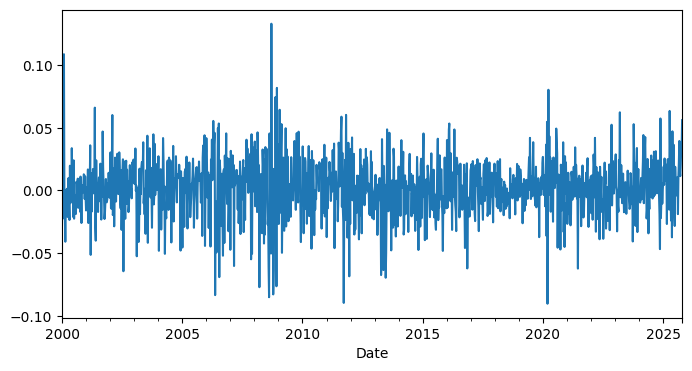

In [54]:

df_gold['log return gold'] = np.log(df_gold['Price']).diff()
df_gold['log return gold'].plot(figsize = (8,4))

In [56]:
df_gold.index = pd.to_datetime(df_gold.index.astype(str), utc=True).strftime('%Y-%m-%d')
df_gold = df_gold[["log return gold"]].rename(columns={"Price":'XAU_USD'})

In [57]:
df_gold

,log return gold
Date,
2000-01-07,NaN
2000-01-14,0.007954
2000-01-21,0.017798
2000-01-28,-0.022210
2000-02-04,0.108644
...,...
2025-09-19,0.011422
2025-09-26,0.020218
2025-10-03,0.033111


We get index level data on the S&P500 through https://wrds-www.wharton.upenn.edu

In [209]:
data_path = os.path.join('data', 'US', 'sp500.csv')
df_sp500 = pd.read_csv(data_path, index_col=0)
df_sp500.index = pd.to_datetime(df_sp500.index, utc=True).strftime('%Y-%m-%d')

<Axes: xlabel='DlyCalDt'>

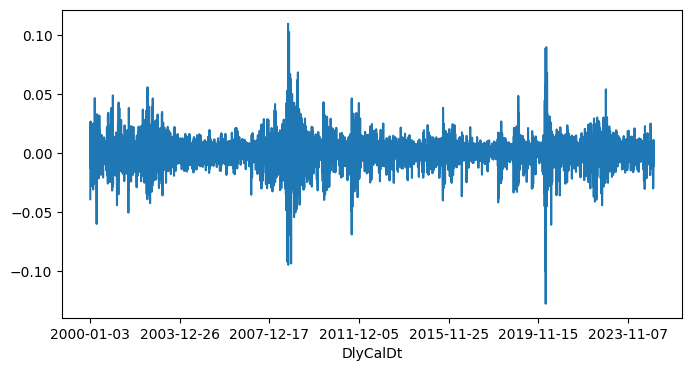

In [210]:
df_sp500['log return sp500'] = np.log(df_sp500['spindx']).diff()
df_sp500['log return sp500'].sort_index().plot(figsize=(8,4))

In [211]:
df_sp500 = df_sp500['log return sp500']

### 3) Merge data

We inner merge our three DataFrames on their date indices. 

In [212]:
df = df.merge(right=df_gold, how='inner', left_index=True, right_index=True).merge(right=df_sp500, how='inner', left_index=True, right_index=True)

In [ ]:
data_path = os.path.join('data', 'US', 'us_data_weekly.csv')
df.to_csv(data_path)